In [532]:
import pickle
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import natsort
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import adjusted_rand_score
import analysis
import datasets


def show_best_dim_cors(groupCoordinates, modelInfo, modelNames):
    numericalCols = [
        "Parameters",
        "Layers",
        "Residual Blocks",
        "Conv Layers",
        "Dense Layers",
        "Bottlenecks",
        "Pooling Layers",
        "Normalization Layers",
        "Recurrent Layers",
        "Attention Layers",
        "Output Features",
        "First Layer Parameters",
        "Highest Internal Layer Parameters",
        "Lowest Internal Layer Parameters",
        "Last Layer Parameters",
    ]

    # Loop through dimensions of gspace
    dimDict = {}
    for i in range(groupCoordinates.shape[1]):
        print(f"Dimension {i + 1}")

        dimDict[i] = {}

        # Loop through numericalCols
        for col in numericalCols:
            coords = np.array([])
            values = np.array([])

            for j, model in enumerate(modelNames):
                if (
                    model in modelInfo["Model"].values
                    and not pd.isna(
                        modelInfo.loc[modelInfo["Model"] == model, col].values[0]
                    )
                    and modelInfo.loc[modelInfo["Model"] == model, col].values[0] != 0
                ):
                    coords = np.append(coords, groupCoordinates[j, i])
                    values = np.append(
                        values, modelInfo[modelInfo["Model"] == model][col].values[0]
                    )

            # Get correlation if there's enough values
            if len(values) < 500:
                print(f"Only have {len(values)} values for {col} and dim {i}")
                continue

            correlation = np.corrcoef(coords, values)[0, 1]
            # print(
            #     f"Correlation between {col} and dim {i}: r({len(values)}) = {correlation}"
            # )

            dimDict[i][col] = {
                "values": values,
                "coords": coords,
                "cor": correlation,
            }

        cors = [
            (idx, abs(dimDict[i][col]["cor"]))
            for idx, col in enumerate(dimDict[i].keys())
        ]
        cors = sorted(cors, key=lambda x: x[1], reverse=True)
        # Print out sorted correlations
        print("Sorted correlations:")
        for idx, cor in cors:
            print(f"{list(dimDict[i].keys())[idx]}: {cor}")

        print("==")

    return dimDict


def plot_mds(
    ax, coordinates, modelInfo, modelNames, dim1, dim2, sizeCol, colorCol, showName
):
    # Make a color scale
    colorMin = modelInfo[colorCol].min()
    colorMax = modelInfo[colorCol].max()
    colorNorm = matplotlib.colors.Normalize(vmin=colorMin, vmax=colorMax)
    colorMapper = matplotlib.cm.ScalarMappable(norm=colorNorm, cmap=matplotlib.cm.cool)

    # Make a size scale
    sizeMin = modelInfo[sizeCol].min()
    sizeMax = modelInfo[sizeCol].max()
    sizeNorm = matplotlib.colors.Normalize(vmin=sizeMin, vmax=sizeMax)
    minSize = 30
    maxSize = 1000

    for i, modelName in enumerate(modelNames):
        x = coordinates[i, dim1]
        y = coordinates[i, dim2]

        # Find the row in modelInfo
        row = modelInfo[modelInfo["Model"] == modelName]
        if row.empty:
            # Make the marker an x
            size = minSize
            marker = "x"
            color = "black"
        else:
            # Check if columns are NaN
            if pd.isna(row[colorCol].values[0]):
                color = "black"
            else:
                value = row[colorCol].values[0]
                color = colorMapper.to_rgba(value) if value > 0 else "gray"

            if pd.isna(row[sizeCol].values[0]):
                size = minSize
                marker = "x"
            else:
                value = row[sizeCol].values[0]
                size = minSize + (maxSize - minSize) * sizeNorm(value)
                marker = "o" if value > 0 else "s"

        ax.scatter(x, y, s=size, marker=marker, color=color, alpha=1, edgecolor="black")

        if showName:
            ax.text(x, y, modelName)

    # Label axes
    ax.set_xlabel(f"Dim {dim1+1}")
    ax.set_ylabel(f"Dim {dim2+1}")

    # Add annotation for color and size
    ax.text(
        0.99,
        0.01,
        f"Color: {colorCol}",
        verticalalignment="bottom",
        horizontalalignment="right",
        transform=ax.transAxes,
    )
    ax.text(
        0.99,
        0.03,
        f"Size: {sizeCol}",
        verticalalignment="bottom",
        horizontalalignment="right",
        transform=ax.transAxes,
    )


def plot_all_mds(coordinates, modelInfo, modelNames, dimCols, showName):
    # Check how many dimensions we have
    numDims = coordinates.shape[1]

    # Loop through dimensions, 2 at a time
    for i in range(int(np.ceil(numDims / 2))):
        # Make a figure
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))

        # Get the dimensions to plot
        dim1 = i * 2
        dim2 = i * 2 + 1

        # Last plot so duplicate a dimension
        if dim2 >= numDims:
            dim2 = dim1
            dim1 = (i - 1) * 2

        plot_mds(
            ax,
            coordinates,
            modelInfo,
            modelNames,
            dim1,
            dim2,
            dimCols[dim1],
            dimCols[dim2],
            showName,
        )

        fig.show()


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [185]:
indscalFiles = os.listdir("../data_storage/indscal")
indscalFiles = natsort.natsorted(indscalFiles)

# Load indscal results
indscalResults = []
for file in indscalFiles:
    with open("../data_storage/indscal/" + file, "rb") as f:
        results = pickle.load(f)

        # Add n dims basd on file name
        results["nDims"] = int(file.split("_")[1].replace("d", ""))

        indscalResults.append(results)

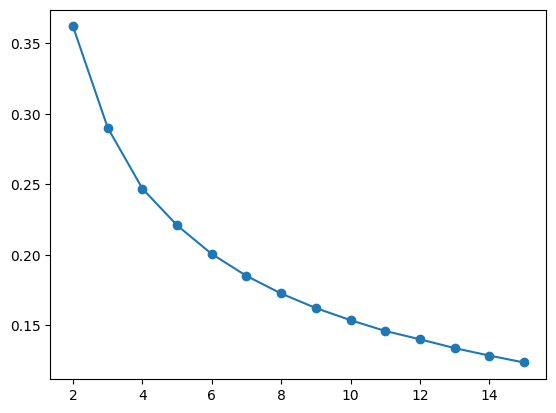

In [186]:
# Plot stress elbow plot
indscalStress = [result["stress"] for result in indscalResults]
nDims = [result["nDims"] for result in indscalResults]
plt.plot(nDims, indscalStress, marker="o")

In [433]:
firstFile = list(datasets._DATA_DIRS.keys())[0]

# Load the first dataset to get info
data = pd.read_csv(f"../data_storage/sims/{firstFile}.csv", index_col=0)
modelNames = data.columns

modelInfoFiles = [
    "models_summary_keras.csv",
    "models_summary_tfhub.csv",
    "models_summary_pytorch.csv",
    "models_summary_timm_new.csv",
]

# Load each file and concatenate
modelInfo = pd.concat(
    [pd.read_csv(f"../data_storage/modelData/{file}") for file in modelInfoFiles]
)

# Load family data and left join
familyData = pd.read_csv("../data_storage/modelData/family_data.csv")
hasColumns = [
    "Convolutional Layers",
    "Residual Blocks",
    "Dense Layers",
    "Bottlenecks",
    "Recurrent Layers",
    "Skip Connections",
    "Attention Layers",
    "ReLU",
    "GeLU",
]
# Add "has" in front of has columns
familyData = familyData.rename(columns={col: "has " + col for col in hasColumns})

# Rename other relevant columns
familyData = familyData.rename(columns={"Pooling": "Pooling Type"})

# Left join
modelInfo = modelInfo.merge(familyData, on="Family")

# Scale down parameters to be in the millions
modelInfo["Parameters"] = modelInfo["Parameters"] / 1_000_000

# Scale down layers by 10
modelInfo["Layers"] = modelInfo["Layers"] / 10

modelInfo.columns

Index(['Model', 'Parameters', 'Layers', 'Residual Blocks', 'Conv Layers',
       'Dense Layers', 'Bottlenecks', 'Pooling Layers', 'Normalization Layers',
       'Recurrent Layers', 'Attention Layers', 'Output Features',
       'Training Dataset', 'RF25 Layer Number', 'RF25 Layer Name', 'Max RF',
       'Family', 'MAX RF', 'Architecture', 'Crop Percentage',
       'First Layer Parameters', 'Highest Internal Layer Parameters',
       'Lowest Internal Layer Parameters', 'Last Layer Parameters',
       'has Convolutional Layers', 'has Residual Blocks', 'has Dense Layers',
       'has Bottlenecks', 'has Recurrent Layers', 'has Skip Connections',
       'has Attention Layers', 'Tokenized', 'Transformer', 'has ReLU',
       'has GeLU', 'Other', 'Year Made', 'Learning Type',
       'Primary Application', 'Key Distinguishing Feature', 'Pooling Type'],
      dtype='object')

In [353]:
groupCoordinates = indscalResults[0]["gspace"]
_ = show_best_dim_cors(groupCoordinates, modelInfo, modelNames)

Dimension 1
Only have 153 values for Residual Blocks and dim 0
Only have 199 values for Bottlenecks and dim 0
Only have 241 values for Pooling Layers and dim 0
Only have 3 values for Recurrent Layers and dim 0
Only have 236 values for Attention Layers and dim 0
Sorted correlations:
Dense Layers: 0.3542288360941396
Layers: 0.3429619297003583
Parameters: 0.1847247915346224
Highest Internal Layer Parameters: 0.18349060775742546
Normalization Layers: 0.14202893159583965
First Layer Parameters: 0.11555094779253482
Last Layer Parameters: 0.10339700213126968
Conv Layers: 0.10264536068600721
Output Features: 0.07779002061881587
Lowest Internal Layer Parameters: 0.015002459972643418
==
Dimension 2
Only have 153 values for Residual Blocks and dim 1
Only have 199 values for Bottlenecks and dim 1
Only have 241 values for Pooling Layers and dim 1
Only have 3 values for Recurrent Layers and dim 1
Only have 236 values for Attention Layers and dim 1
Sorted correlations:
Highest Internal Layer Paramete

/tmp/ipykernel_2253930/3604802352.py:130: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, s=size, marker=marker, color=color, alpha=1, edgecolor="black")


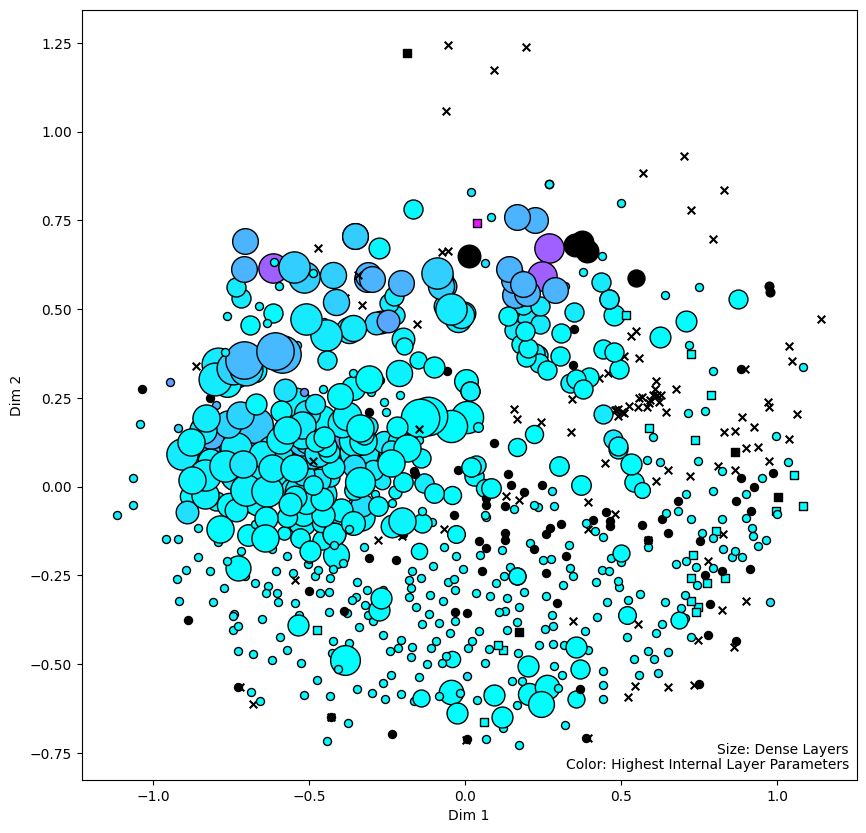

In [354]:
plot_all_mds(
    groupCoordinates,
    modelInfo,
    modelNames,
    dimCols=["Dense Layers", "Highest Internal Layer Parameters"],
    showName=False,
)

In [348]:
groupCoordinates = indscalResults[1]["gspace"]
_ = show_best_dim_cors(groupCoordinates, modelInfo, modelNames)

Dimension 1
Only have 153 values for Residual Blocks and dim 0
Only have 199 values for Bottlenecks and dim 0
Only have 241 values for Pooling Layers and dim 0
Only have 3 values for Recurrent Layers and dim 0
Only have 236 values for Attention Layers and dim 0
Sorted correlations:
Layers: 0.292730777002294
Dense Layers: 0.29035397898820164
Parameters: 0.13511099727998102
Highest Internal Layer Parameters: 0.13469277929495324
Normalization Layers: 0.1154101854015224
Last Layer Parameters: 0.11167935102944566
Output Features: 0.09936492206297179
Conv Layers: 0.09803378231472955
First Layer Parameters: 0.08560145370879609
Lowest Internal Layer Parameters: 0.01729879490325864
==
Dimension 2
Only have 153 values for Residual Blocks and dim 1
Only have 199 values for Bottlenecks and dim 1
Only have 241 values for Pooling Layers and dim 1
Only have 3 values for Recurrent Layers and dim 1
Only have 236 values for Attention Layers and dim 1
Sorted correlations:
Dense Layers: 0.5837826724999214

/tmp/ipykernel_2253930/3604802352.py:130: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, s=size, marker=marker, color=color, alpha=1, edgecolor="black")
/tmp/ipykernel_2253930/3604802352.py:130: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, s=size, marker=marker, color=color, alpha=1, edgecolor="black")


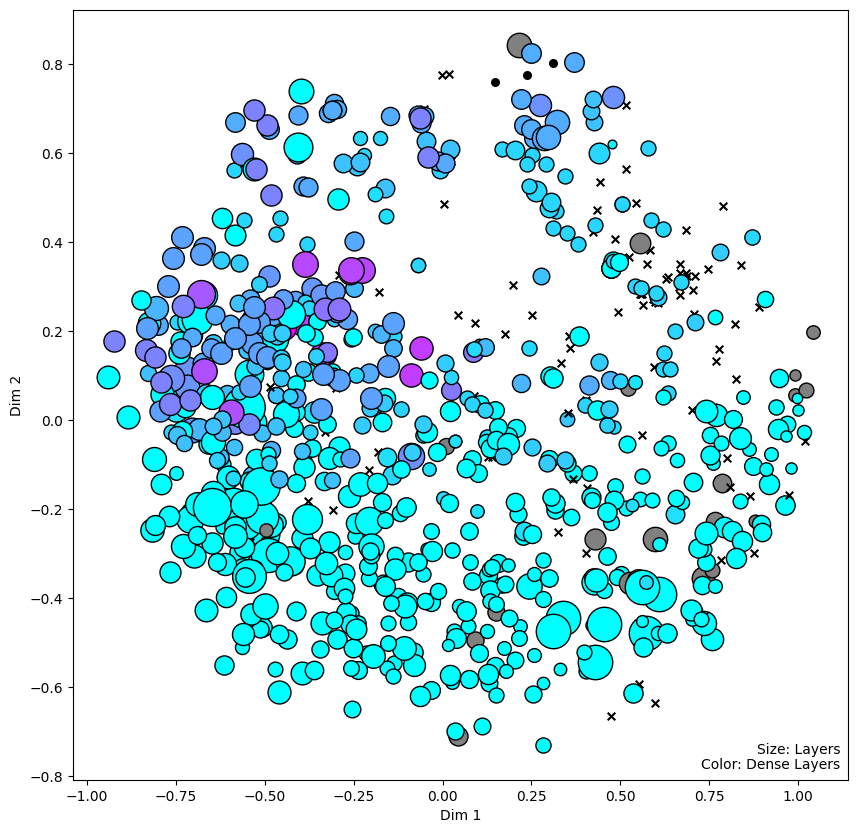

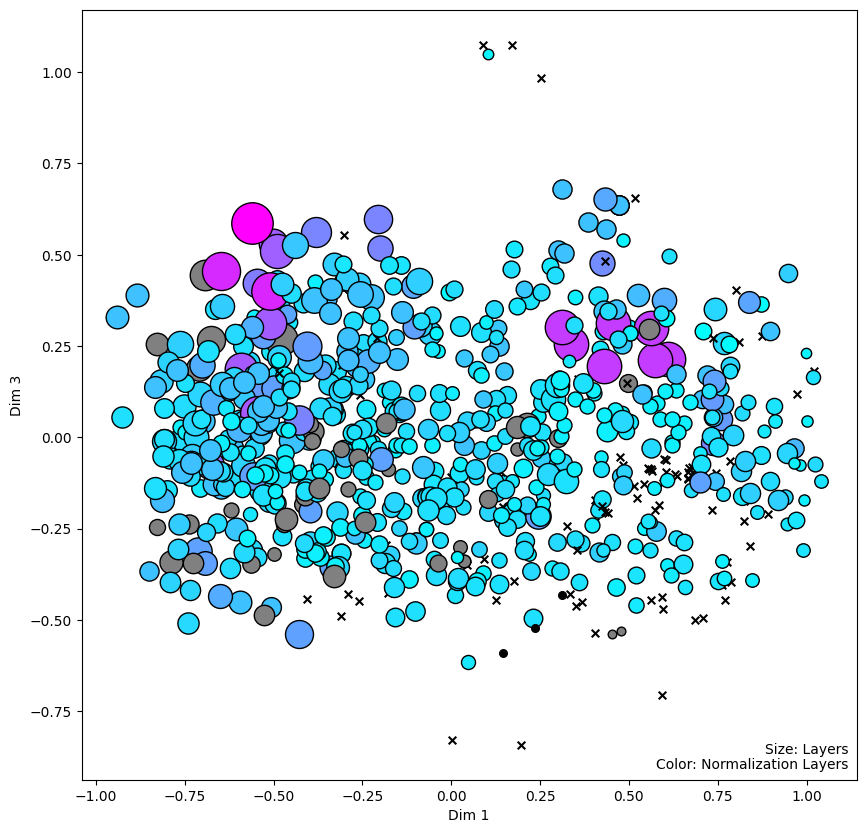

In [352]:
plot_all_mds(
    groupCoordinates,
    modelInfo,
    modelNames,
    dimCols=["Layers", "Dense Layers", "Normalization Layers"],
    showName=False,
)

In [330]:
groupCoordinates = indscalResults[2]["gspace"]
_ = show_best_dim_cors(groupCoordinates, modelInfo, modelNames)

Dimension 1
Only have 153 values for Residual Blocks and dim 0
Only have 199 values for Bottlenecks and dim 0
Only have 241 values for Pooling Layers and dim 0
Only have 3 values for Recurrent Layers and dim 0
Only have 236 values for Attention Layers and dim 0
Sorted correlations:
Dense Layers: 0.35939329894966754
Layers: 0.20405553755447778
Last Layer Parameters: 0.12185626134160187
First Layer Parameters: 0.12034287440317712
Highest Internal Layer Parameters: 0.10981456935778151
Parameters: 0.10242142387405216
Output Features: 0.08658410783665056
Lowest Internal Layer Parameters: 0.03379783596706926
Normalization Layers: 0.013212588809473248
Conv Layers: 0.010641064410430733
==
Dimension 2
Only have 153 values for Residual Blocks and dim 1
Only have 199 values for Bottlenecks and dim 1
Only have 241 values for Pooling Layers and dim 1
Only have 3 values for Recurrent Layers and dim 1
Only have 236 values for Attention Layers and dim 1
Sorted correlations:
Dense Layers: 0.55214708767

/tmp/ipykernel_2253930/2387424237.py:130: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, s=size, marker=marker, color=color, alpha=1, edgecolor="black")


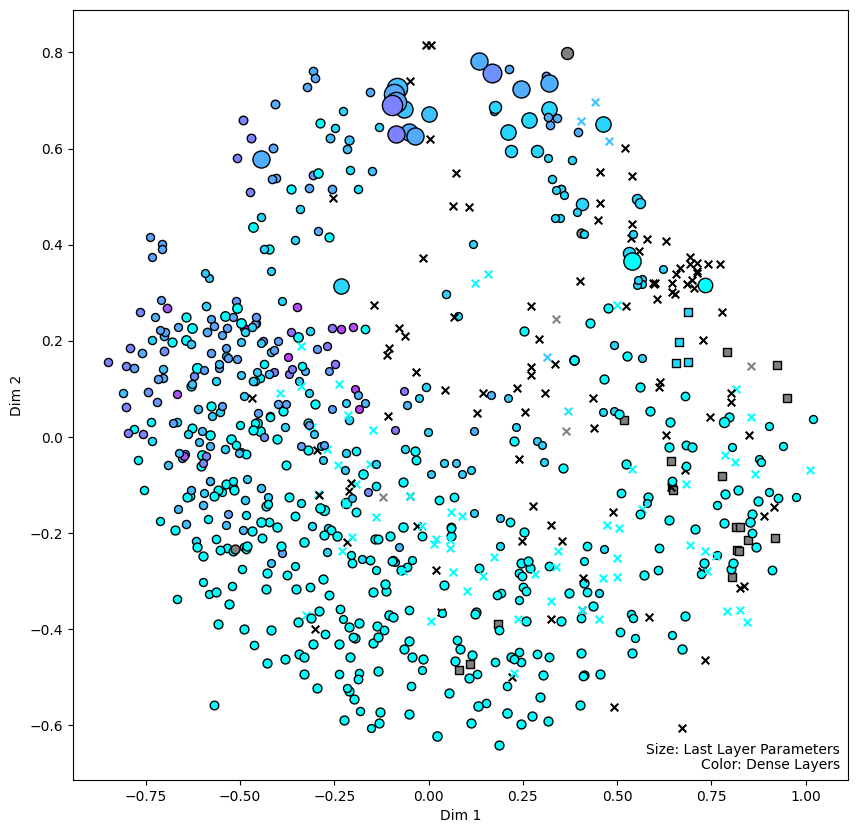

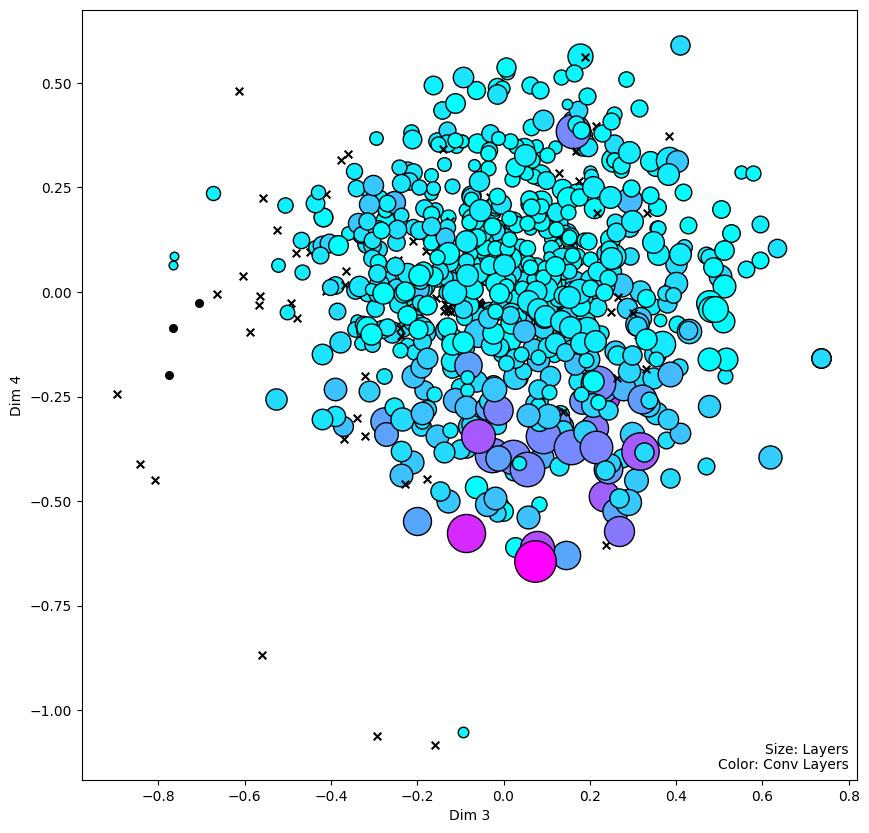

In [346]:
plot_all_mds(
    groupCoordinates,
    modelInfo,
    modelNames,
    dimCols=["Last Layer Parameters", "Dense Layers", "Layers", "Conv Layers"],
    showName=False,
)

In [374]:
nDims = indscalResults[2]["cweights"].shape[0]
datasetNames = list(datasets._DATA_DIRS.keys())

dimWeights = []
for i in range(nDims):
    weights = indscalResults[2]["cweights"][i, i, :]
    dimWeights += [weights]

    for j, dataset in enumerate(datasetNames):
        print(f"Dim {i+1}, {dataset}: {weights[j]}")

    print("==")
dimWeights = np.stack(dimWeights, axis=0)

dimWeights

Dim 1, fribbles: 0.6941720015782724
Dim 1, greebles: 0.6373675981453496
Dim 1, yufos: 0.7262267333646694
Dim 1, ziggerins: 0.6757579012049467
Dim 1, ecoset: 0.914390979126353
Dim 1, CUB200: 0.7493082641821598
Dim 1, cars196: 0.7970914001590885
Dim 1, kiani: 0.9316713958678139
Dim 1, VGGFace: 0.8456806523676499
==
Dim 2, fribbles: 0.7464367694247573
Dim 2, greebles: 0.8278396095645372
Dim 2, yufos: 1.032693909858894
Dim 2, ziggerins: 0.9532078272954763
Dim 2, ecoset: 1.0798397696981223
Dim 2, CUB200: 1.1894888201962193
Dim 2, cars196: 1.0317192772506776
Dim 2, kiani: 1.0028679849138553
Dim 2, VGGFace: 1.101259352347426
==
Dim 3, fribbles: 1.3712556218025138
Dim 3, greebles: 1.2405919781991819
Dim 3, yufos: 1.2874014377217695
Dim 3, ziggerins: 1.4211755975553244
Dim 3, ecoset: 1.1823897135060137
Dim 3, CUB200: 1.3824866035020391
Dim 3, cars196: 1.4989728623941083
Dim 3, kiani: 1.2035889268392022
Dim 3, VGGFace: 1.2686533801425783
==
Dim 4, fribbles: 1.703888317245379
Dim 4, greebles: 1.8

array([[0.694172  , 0.6373676 , 0.72622673, 0.6757579 , 0.91439098,
        0.74930826, 0.7970914 , 0.9316714 , 0.84568065],
       [0.74643677, 0.82783961, 1.03269391, 0.95320783, 1.07983977,
        1.18948882, 1.03171928, 1.00286798, 1.10125935],
       [1.37125562, 1.24059198, 1.28740144, 1.4211756 , 1.18238971,
        1.3824866 , 1.49897286, 1.20358893, 1.26865338],
       [1.70388832, 1.8060104 , 1.41666647, 1.51061153, 1.08172376,
        1.10793704, 1.1086259 , 1.15025721, 1.18829385]])

In [347]:
groupCoordinates = indscalResults[3]["gspace"]
_ = show_best_dim_cors(groupCoordinates, modelInfo, modelNames)

Dimension 1
Only have 153 values for Residual Blocks and dim 0
Only have 199 values for Bottlenecks and dim 0
Only have 241 values for Pooling Layers and dim 0
Only have 3 values for Recurrent Layers and dim 0
Only have 236 values for Attention Layers and dim 0
Sorted correlations:
Dense Layers: 0.306494286352686
Layers: 0.19306003815945466
First Layer Parameters: 0.12252045892282018
Last Layer Parameters: 0.11664304482735584
Output Features: 0.09567427885649024
Highest Internal Layer Parameters: 0.07942316125670403
Parameters: 0.07151203920414162
Lowest Internal Layer Parameters: 0.03078784325118902
Normalization Layers: 0.025993760544358046
Conv Layers: 0.016196571253617998
==
Dimension 2
Only have 153 values for Residual Blocks and dim 1
Only have 199 values for Bottlenecks and dim 1
Only have 241 values for Pooling Layers and dim 1
Only have 3 values for Recurrent Layers and dim 1
Only have 236 values for Attention Layers and dim 1
Sorted correlations:
Dense Layers: 0.5458086944386

/data/venv/research/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:3409: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ivl.append(labels[int(i - n)])


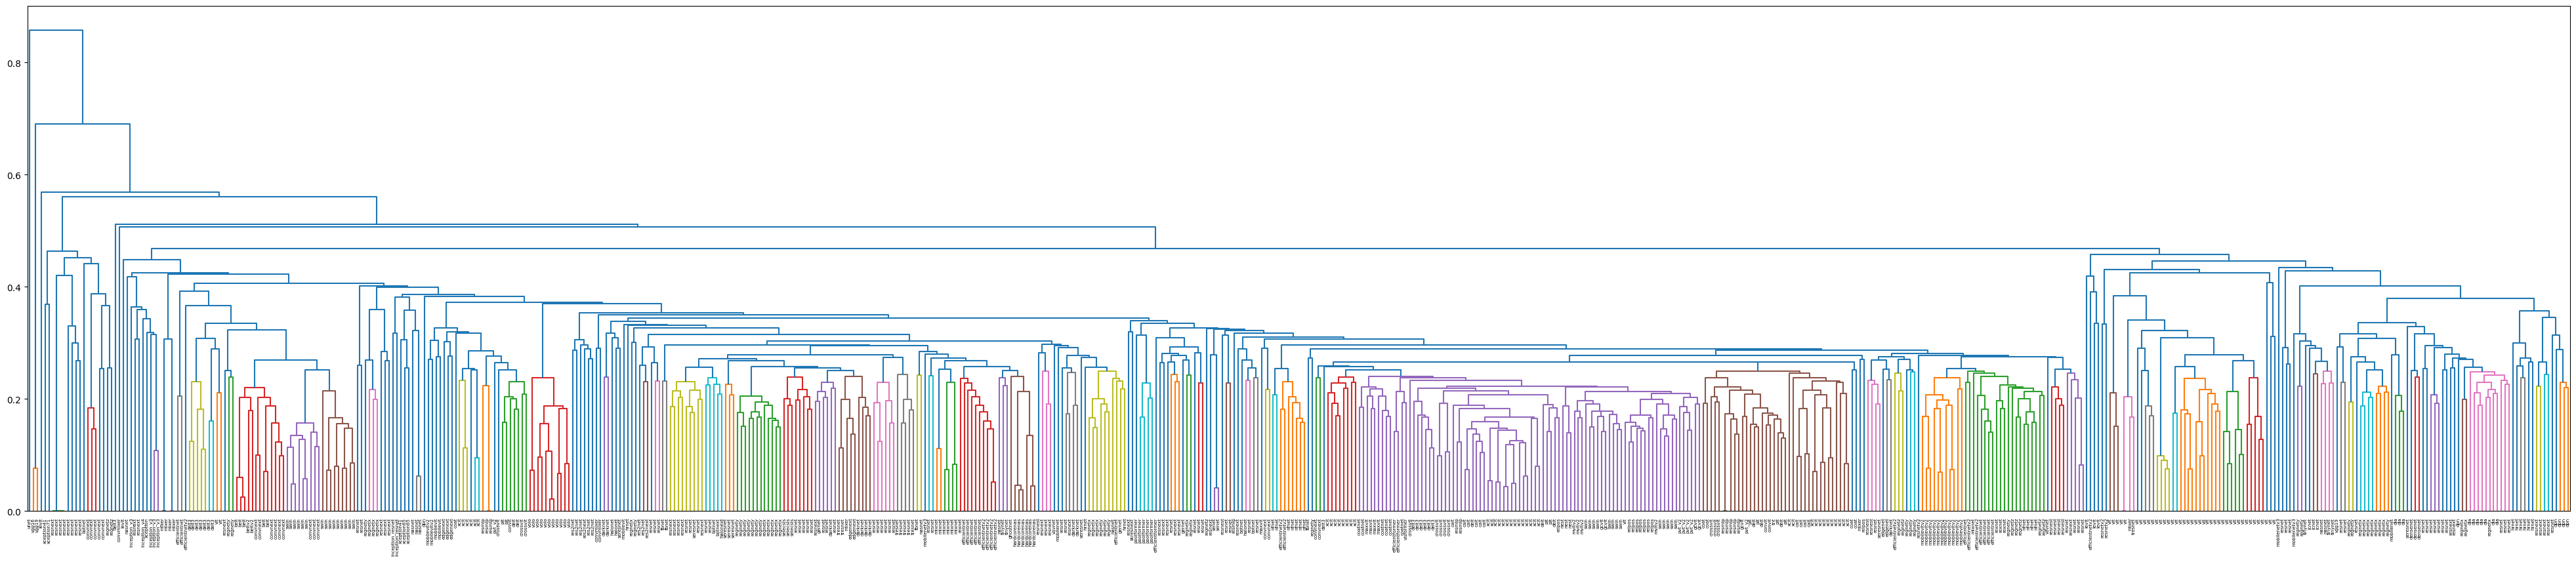

In [548]:
# Load all sims
simFiles = os.listdir("../data_storage/sims")
simFiles = sorted(simFiles)

# Load the first dataset to get info
simMat = pd.read_csv(f"../data_storage/sims/{simFiles[0]}", index_col=0)

modelNames = list(simMat.columns)

# Turn simMat into an array
simMat = simMat.values

# Loop through the rest
for file in simFiles[1:]:
    # Load the simMat
    tmp = pd.read_csv(f"../data_storage/sims/{file}", index_col=0)

    # Make sure the columns are in the same order
    tmp = tmp[modelNames]

    # Make sure the rows are in the same order
    tmp = tmp.loc[modelNames]

    # Add to simMat
    simMat += tmp.values

simMat = simMat / len(simFiles)
distMat = 1 - simMat
distMat[distMat < 0] = 0

categoricalCols = [
    "has Convolutional Layers",
    "has Residual Blocks",
    "has Dense Layers",
    "has Bottlenecks",
    "has Recurrent Layers",
    "has Skip Connections",
    "has Attention Layers",
    "Tokenized",
    "Transformer",
    "has ReLU",
    "has GeLU",
    "Pooling Type",
]

# Make a new column combining a few interesting columns
comboCols = ["has Residual Blocks", "has Attention Layers", "has ReLU", "has GeLU"]
modelInfo["Combo"] = modelInfo[comboCols].apply(
    lambda x: "-".join(x.astype(str)), axis=1
)

categoricalCols += ["Combo"]

# Make sure modelInfo has the same order as modelNames
clusterModelInfo = modelInfo.loc[modelInfo["Model"].isin(modelNames)]
clusterModelInfo = clusterModelInfo.drop_duplicates(subset="Model")
clusterModelNames = clusterModelInfo["Model"].values

# Find the models not in clusterModelInfo
missingModels = [model for model in modelNames if model not in clusterModelNames]

# Remove these models from the distance matrix
missingIdx = [modelNames.index(model) for model in missingModels]
distMat = np.delete(distMat, missingIdx, axis=0)
distMat = np.delete(distMat, missingIdx, axis=1)
modelNames = [model for model in modelNames if model in clusterModelNames]

# Only keep rows in modelNames
clusterModelInfo = clusterModelInfo.loc[clusterModelInfo["Model"].isin(modelNames)]

# Reorder the rows to match modelNames
clusterModelInfo = clusterModelInfo.set_index("Model").loc[modelNames]


clusters = linkage(squareform(distMat), method="average")

fig, ax = plt.subplots(1, 1, figsize=(50, 10))
_ = dendrogram(
    clusters,
    # truncate_mode="distance",
    # p=15,
    color_threshold=0.25,
    labels=clusterModelInfo["Family"],
    leaf_font_size=5,
    ax=ax,
)

# Save fig
fig.savefig("dendrogram.png", dpi=300, bbox_inches="tight")

In [549]:
len(clusterModelInfo["Combo"].unique())

14

In [533]:
flatClusters = fcluster(clusters, t=81, criterion="maxclust")
adjusted_rand_score(clusterModelInfo["Family"], flatClusters)

0.0807083252496637

In [552]:
distRange = np.linspace(0.1, 0.4, 50)
for col in categoricalCols:
    print(f"== {col} ==")
    scores = []
    for t in distRange:
        flatClusters = fcluster(clusters, t=t, criterion="distance")
        score = adjusted_rand_score(clusterModelInfo[col], flatClusters)
        scores.append(score)

        print(f"t = {t}, score = {score}")

    # Get the highest score and its corresponding t
    bestScore = max(scores)
    bestIdx = scores.index(bestScore)
    print(f"Best score: t = {distRange[bestIdx]}, score = {bestScore}")

# Also do "Family" column
scores = []
print("== Family ==")
for t in distRange:
    flatClusters = fcluster(clusters, t=t, criterion="distance")
    score = adjusted_rand_score(clusterModelInfo["Family"], flatClusters)
    scores.append(score)

    print(f"t = {t}, score = {score}")

# Get the highest score and its corresponding t
bestScore = max(scores)
bestIdx = scores.index(bestScore)
print(f"Best score: t = {distRange[bestIdx]}, score = {bestScore}")

== has Convolutional Layers ==
t = 0.1, score = 0.0004675682014443162
t = 0.10612244897959185, score = 0.0004963439018769705
t = 0.11224489795918369, score = 0.000532313897990176
t = 0.11836734693877551, score = 0.0005754784368415237
t = 0.12448979591836735, score = 0.0006761980000506619
t = 0.1306122448979592, score = 0.0007913100254057144
t = 0.13673469387755102, score = 0.0008776468117362772
t = 0.14285714285714285, score = 0.0009999613196218925
t = 0.1489795918367347, score = 0.0014173054728942882
t = 0.15510204081632656, score = 0.0015252483264090175
t = 0.16122448979591839, score = 0.0020196526833760643
t = 0.1673469387755102, score = 0.0022192579239801572
t = 0.17346938775510207, score = 0.0027628596484523815
t = 0.1795918367346939, score = 0.0032047169687841816
t = 0.18571428571428572, score = 0.0031095101457258127
t = 0.19183673469387758, score = 0.0036533799008153325
t = 0.1979591836734694, score = 0.00427290580086099
t = 0.20408163265306123, score = 0.004232303836539279
t = 

In [546]:
distRange = np.linspace(0.1, 0.4, 50)
scores = []
for t in distRange:
    flatClusters = fcluster(clusters, t=t, criterion="distance")
    score = adjusted_rand_score(clusterModelInfo["Family"], flatClusters)
    scores.append(score)

    print(f"t = {t}, score = {score}")

t = 0.1, score = 0.019060488973328963
t = 0.10612244897959185, score = 0.020240674747257298
t = 0.11224489795918369, score = 0.021713993739043837
t = 0.11836734693877551, score = 0.023479176524998063
t = 0.12448979591836735, score = 0.027586100223591918
t = 0.1306122448979592, score = 0.03195416427049718
t = 0.13673469387755102, score = 0.03544572453122144
t = 0.14285714285714285, score = 0.03915517124385451
t = 0.1489795918367347, score = 0.055189469150519664
t = 0.15510204081632656, score = 0.05884722433882264
t = 0.16122448979591839, score = 0.06651080925385117
t = 0.1673469387755102, score = 0.07466879920315111
t = 0.17346938775510207, score = 0.09277642348682924
t = 0.1795918367346939, score = 0.10402886196580052
t = 0.18571428571428572, score = 0.11289401668652593
t = 0.19183673469387758, score = 0.1273409276248841
t = 0.1979591836734694, score = 0.1346083900810989
t = 0.20408163265306123, score = 0.13952447675450447
t = 0.21020408163265308, score = 0.14864146471707815
t = 0.2163

In [496]:
len(modelNames)

650

In [498]:
len(clusterModelInfo)

650

In [463]:
missingModels

['alexnet',
 'beit_base_patch16_224.in22k_ft_in22k',
 'beit_large_patch16_224.in22k_ft_in22k',
 'beitv2_base_patch16_224.in1k_ft_in22k',
 'beitv2_large_patch16_224.in1k_ft_in22k',
 'bit-m-r101x1',
 'bit-m-r50x1',
 'bit-s-r50x1',
 'bninception',
 'cropnet-feature_vector-cassava_disease_V1',
 'cropnet-feature_vector-concat',
 'cropnet-feature_vector-imagenet',
 'densenet121.tv_in1k',
 'efficientnet-b0-feature-vector',
 'efficientnet-b1-feature-vector',
 'efficientnet-b2-feature-vector',
 'efficientnet-b3-feature-vector',
 'efficientnet-b4-feature-vector',
 'efficientnet-b5-feature-vector',
 'efficientnet-b7-feature-vector',
 'experts-bit-r50x1-in21k-abstraction',
 'experts-bit-r50x1-in21k-animal',
 'experts-bit-r50x1-in21k-arthropod',
 'experts-bit-r50x1-in21k-artifact',
 'experts-bit-r50x1-in21k-consumer_goods',
 'experts-bit-r50x1-in21k-conveyance',
 'experts-bit-r50x1-in21k-flower',
 'experts-bit-r50x1-in21k-food',
 'experts-bit-r50x1-in21k-instrument',
 'experts-bit-r50x1-in21k-matte